In [1]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import timm
import warnings

warnings.filterwarnings('ignore')

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [2]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [3]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_LAUNCH_BLOCKING'] = "2"
os.environ['CUDA_VISIBLE_DEVICES']="2"

In [5]:
import torch

torch.cuda.current_device()
torch.cuda.is_available()

True

In [6]:
TRAIN_DATASET = sorted([x for x in Path("./data//train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("./data//test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("./data/validation/").glob("*.csv")])

In [7]:
TRAIN = dataframe_from_csvs(TRAIN_DATASET)
TRAIN.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET[:5])
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)

VAL_DF_RAW = dataframe_from_csv(TRAIN_DATASET[5])
VAL_DF_RAW.reset_index(drop=True,inplace=True)

In [8]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [9]:
TAG_MIN = TRAIN[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [10]:
WINDOW_GIVEN = 12
WINDOW_SIZE = WINDOW_GIVEN + 1
EPOCHS = 20


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        
        return item

In [11]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [12]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
VAL_DF = normalize(VAL_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [13]:
train_dataset = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
val_dataset = HaiDataset(VAL_DF_RAW[TIMESTAMP_FIELD], VAL_DF, stride=1)

  0%|          | 0/745190 [00:00<?, ?it/s]

# of valid windows: 745142


  0%|          | 0/259188 [00:00<?, ?it/s]

# of valid windows: 259188


In [14]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [15]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
import torch
import argparse
import numpy as np
import torch.utils.data as data_utils
from tqdm import tqdm

class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        return (self.even(x), self.odd(x))


class Interactor(nn.Module):
    def __init__(self, in_planes, splitting=True,
                 kernel = 5, dropout=0.5, groups = 1, hidden_size = 1, INN = True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups
        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1
            pad_r = self.dilation * (self.kernel_size) // 2 + 1

        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1
        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),

            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)

            return (x_even_update, x_odd_update)

        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)

            return (c, d)


class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes = in_planes, splitting=True,
                 kernel = kernel, dropout=dropout, groups = groups, hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)

class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes= in_planes, kernel = kernel_size, dropout = dropout, groups =groups , hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1)

class SCINet_Tree(nn.Module):
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level


        self.workingblock = LevelSCINet(
            in_planes = in_planes,
            kernel_size = kernel_size,
            dropout = dropout,
            groups= groups,
            hidden_size = hidden_size,
            INN = INN)


        if current_level!=0:
            self.SCINet_Tree_odd=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
    
    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2)
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: 
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_,0).permute(1,0,2)
        
    def forward(self, x):
        x_even_update, x_odd_update= self.workingblock(x)
        if self.current_level ==0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_planes = in_planes,
            current_level = num_levels-1,
            kernel_size = kernel_size,
            dropout =dropout ,
            groups = groups,
            hidden_size = hidden_size,
            INN = INN)
        
    def forward(self, x):

        x= self.SCINet_Tree(x)

        return x

class SCINet(nn.Module):
    def __init__(self, output_len, input_len, input_dim = 9, hid_size = 1, num_stacks = 1,
                num_levels = 3, concat_len = 0, groups = 1, kernel = 5, dropout = 0.5,
                 single_step_output_One = 0, input_len_seg = 0, positionalE = False, modified = True):
        super(SCINet, self).__init__()

        self.input_dim = input_dim
        self.input_len = input_len
        self.output_len = output_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE

        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        if num_stacks == 2:
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        
        if self.single_step_output_One:
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
        else:
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)

        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1
    
        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)
    
    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32, device=x.device)
        temp1 = position.unsqueeze(1)
        temp2 = self.inv_timescales.unsqueeze(0)
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)
    
        return signal

    def forward(self, x):
        assert self.input_len % (np.power(2, self.num_levels)) == 0
        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x += pe[:, :, :-1]
            else:
                x += self.get_position_encoding(x)

        res1 = x
        x = self.blocks1(x)
        x += res1
        x = self.projection1(x)

        if self.stacks == 1:
            return x

        elif self.stacks == 2:
            MidOutPut = x
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:,:], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            res2 = x
            x = self.blocks2(x)
            x += res2
            x = self.projection2(x)
            return x, MidOutPut


def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

In [16]:
print(train_dataset[0]['given'].shape)
print(train_dataset[0]['answer'].shape)

torch.Size([12, 86])
torch.Size([86])


In [17]:
output_len = 1
input_len = WINDOW_GIVEN
input_dim = 86
hid_size = 1
num_stacks = 1
num_levels = 2
concat_len = 0
groups = 1
kernel = 3
dropout = 0.1
lr = 1e-4
batch_size = 4096
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [18]:
model = SCINet(output_len = output_len, input_len= WINDOW_GIVEN, input_dim = input_dim, hid_size = hid_size, num_stacks = num_stacks,
                num_levels = num_levels, concat_len = concat_len, groups = groups, kernel = kernel, dropout = dropout,
                 single_step_output_One = 0, positionalE =  True, modified = True).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [19]:
loss_list = []

for epoch in range(1, EPOCHS+1):
    total_loss = 0
    n = 0
    
    tqdm_dataset = tqdm(train_loader)
    
    for data in tqdm_dataset:
        input_data = data["given"]
        target = data["answer"]
        model.train()
        optimizer.zero_grad()
        pred = model(input_data.to(device))
        loss = loss_function(pred, target.to(device))
        loss.backward()
        optimizer.step()
        total_loss += (loss*input_data.size()[0])
        n += input_data.size()[0]
        
        tqdm_dataset.set_postfix({
                'Epoch': epoch,
                'Loss': '{:06f}'.format(loss.item()),
                'Total Loss' : '{:06f}'.format(total_loss/n)
        })
    val_total_loss = 0
    val_n = 0
    
    torch.cuda.empty_cache()
        
    tqdm_dataset = tqdm(val_loader)
        
    for val_data in tqdm_dataset:
        input_data = data["given"]
        target = data["answer"]
        with torch.no_grad():
            model.eval()
            pred = model(input_data.to(device))
            loss = loss_function(pred, target.to(device))
        val_total_loss += (loss*input_data.size()[0])
        val_n += input_data.size()[0]
        
        tqdm_dataset.set_postfix({
                'Epoch': epoch,
                'Loss': '{:06f}'.format(loss.item()),
                'Total Loss' : '{:06f}'.format(val_total_loss/val_n)
        })
        
    loss_list.append(val_total_loss/val_n)
    
    if epoch == 1:
        min_loss = loss_list[0]
        torch.save(model.state_dict(), f'./models/SCINet.pt')
    else:
        if min_loss > loss_list[epoch - 1]:
            torch.save(model.state_dict(), f'./models/SCINet.pt')
            min_loss = loss_list[epoch - 1]

100%|██████████| 64/64 [00:06<00:00, 10.64it/s, Epoch=20, Loss=0.007793, Total Loss=0.007793]


In [20]:
model = SCINet(output_len = output_len, input_len= WINDOW_GIVEN, input_dim = input_dim, hid_size = hid_size, num_stacks = num_stacks,
                num_levels = num_levels, concat_len = concat_len, groups = groups, kernel = kernel, dropout = dropout,
                 single_step_output_One = 0, positionalE =  True, modified = True)

with open(f'./models/SCINet.pt', "rb") as f:
     saved_state_dict = torch.load(f)
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [21]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [22]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.85).mean()

In [23]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [24]:
HAI_DATASET_VALIDATION = HaiDataset(VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks = VALIDATION_DF_RAW[ATTACK_FIELD])
HAI_DATASET_VALIDATION[0]

  0%|          | 0/86388 [00:00<?, ?it/s]

# of valid windows: 86388


{'attack': 0.0,
 'ts': '2021-07-10 00:00:13',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4527,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3858,  0.0000, -0.0420,  ...,  0.0000,  0.0000,  0.0200],
         ...,
         [ 0.3606,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0760],
         [ 0.4124,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.1053],
         [ 0.4101,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.1270]]),
 'answer': tensor([ 3.7059e-01,  0.0000e+00, -4.0688e-02,  5.1023e-01,  1.5752e-01,
          4.5098e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          3.2487e-01,  3.3039e-01,  3.7251e-01,  4.6134e-01,  3.9176e-01,
          2.3487e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          4.5723e-01,  0.0000e+00,  3.1571e-01,  3.7988e-01,  6.4431e-03,
          0.0000e+00,  3.0876e-01,  2.5990e-01,  0.0000e+00,  9.9559e-01,
          5.8922e-01,  2.4242e-01,  3.2737e-01,  

In [25]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            guess = guess.squeeze()
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [26]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, model.cuda(), batch_size)

CPU times: user 1.73 s, sys: 36.1 ms, total: 1.77 s
Wall time: 1.77 s


In [27]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [28]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

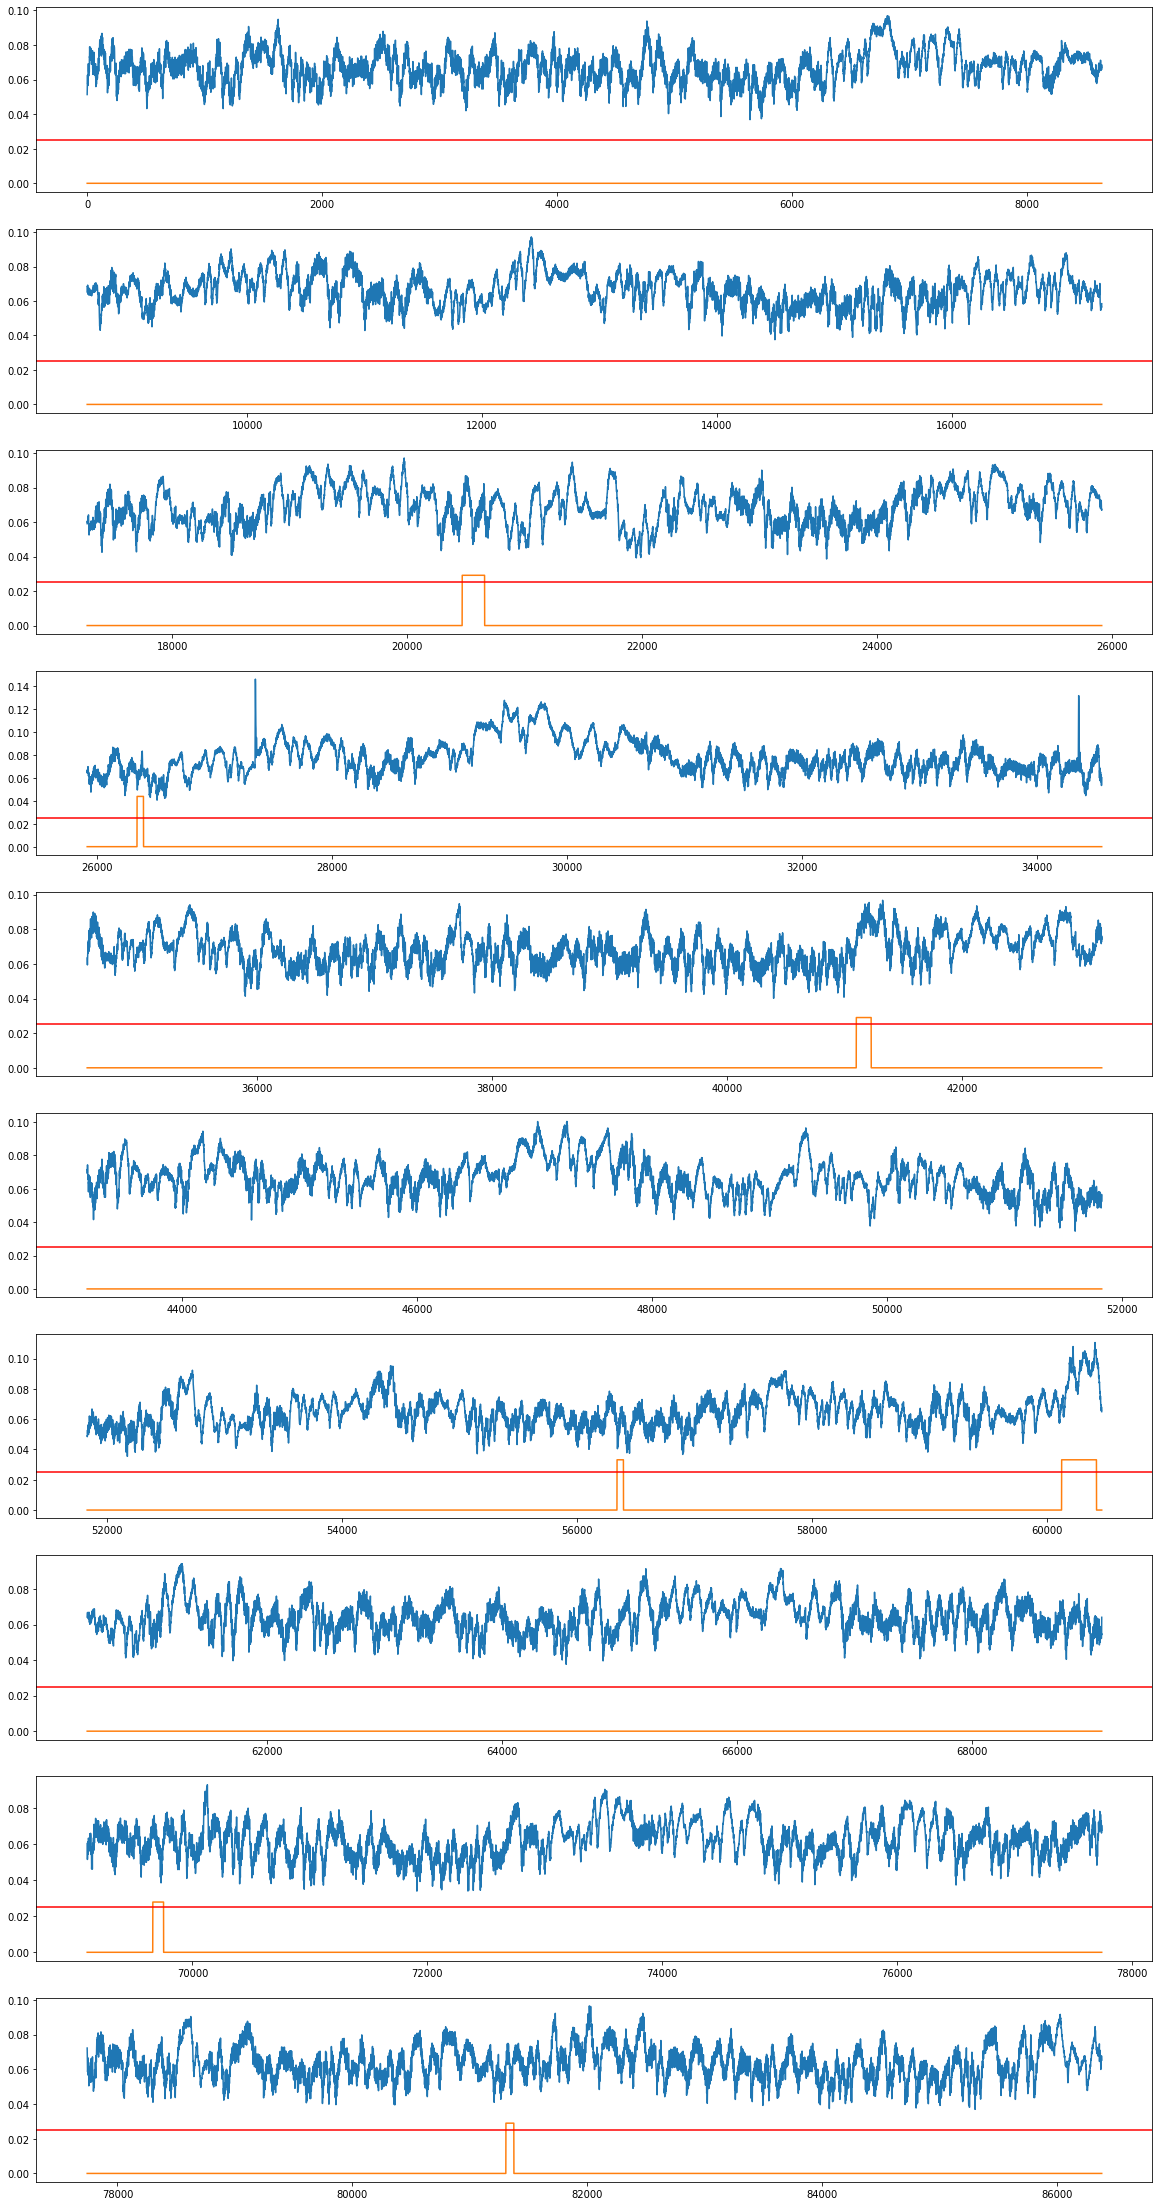

In [29]:
THRESHOLD = 0.025
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=10, THRESHOLD=THRESHOLD)

In [30]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [31]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), (86388,))

In [32]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [33]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [34]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s


(86400,)

In [35]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []


In [36]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


In [37]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.95).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.472452,0.0,0.079812,0.500608,0.077046,0.429799,0.711769,0.0,0.0,0.0,...,0.377783,0.099796,0.285153,0.069294,0.405169,0.0,0.393961,0.0,0.0,0.173514
2,0.458667,0.0,0.079812,0.481838,0.077046,0.409263,0.711769,0.0,0.0,0.0,...,0.378209,0.103832,0.285153,0.068757,0.430902,0.0,0.393961,0.0,0.0,0.176929
3,0.457979,0.0,0.079812,0.478385,0.077046,0.408238,0.711769,0.0,0.0,0.0,...,0.379177,0.109526,0.285153,0.068730,0.463119,0.0,0.393961,0.0,0.0,0.178839
4,0.376417,0.0,0.079812,0.517109,0.077046,0.365615,0.711769,0.0,0.0,0.0,...,0.379225,0.109811,0.285153,0.066651,0.472974,0.0,0.393961,0.0,0.0,0.183066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511825,0.0,0.017216,0.516583,0.147000,0.557293,0.711717,0.0,0.0,0.0,...,0.245387,0.130818,0.240398,0.328219,0.529418,0.0,0.539339,0.0,0.0,0.010225
129596,0.512162,0.0,0.017216,0.458615,0.134574,0.557403,0.711717,0.0,0.0,0.0,...,0.240802,0.131226,0.240398,0.319721,0.541416,0.0,0.539339,0.0,0.0,0.010225
129597,0.555624,0.0,0.017216,0.494613,0.133016,0.592104,0.711717,0.0,0.0,0.0,...,0.240573,0.130552,0.240398,0.305944,0.545915,0.0,0.539339,0.0,0.0,0.010225
129598,0.589332,0.0,0.017216,0.521238,0.132794,0.604801,0.711717,0.0,0.0,0.0,...,0.240561,0.128650,0.240398,0.286801,0.550486,0.0,0.539339,0.0,0.0,0.010225


In [38]:
boundary_check(TEST_DF)

(True, True, False)

In [39]:
THRESHOLD = 0.025

In [40]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_TEST[0]

  0%|          | 0/274788 [00:00<?, ?it/s]

# of valid windows: 274764


{'ts': '2021-07-13 16:00:13',
 'given': tensor([[0.4554, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1688],
         [0.4725, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1735],
         [0.4587, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1769],
         ...,
         [0.3584, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0106],
         [0.4033, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0092],
         [0.4461, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.4708, 0.0000, 0.0798, 0.5062, 0.0770, 0.4338, 0.7118, 0.0000, 0.0000,
         0.0000, 0.4305, 0.3614, 0.5623, 0.1804, 0.5363, 0.2308, 0.0000, 0.0000,
         0.0000, 0.6997, 0.1788, 0.0000, 0.3778, 0.3085, 0.2297, 0.0000, 0.3803,
         0.4608, 0.0000, 0.8325, 0.4087, 0.2393, 0.3999, 0.0000, 0.2850, 0.0000,
         0.0577, 0.0000, 0.0000, 0.0160, 0.2837, 0.5161, 0.3748, 0.4891, 1.0000,
         1.0000, 0.9935, 1.0000, 0.0000, 0.6098, 0.8660, 0.0000, 0.2669, 0.0118,
         0.0000, 0.4581, 0.3181, 0.1386, 0.2671, 0.6345, 1.

In [41]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, model, batch_size)

CPU times: user 5.36 s, sys: 200 ms, total: 5.56 s
Wall time: 5.56 s


In [42]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

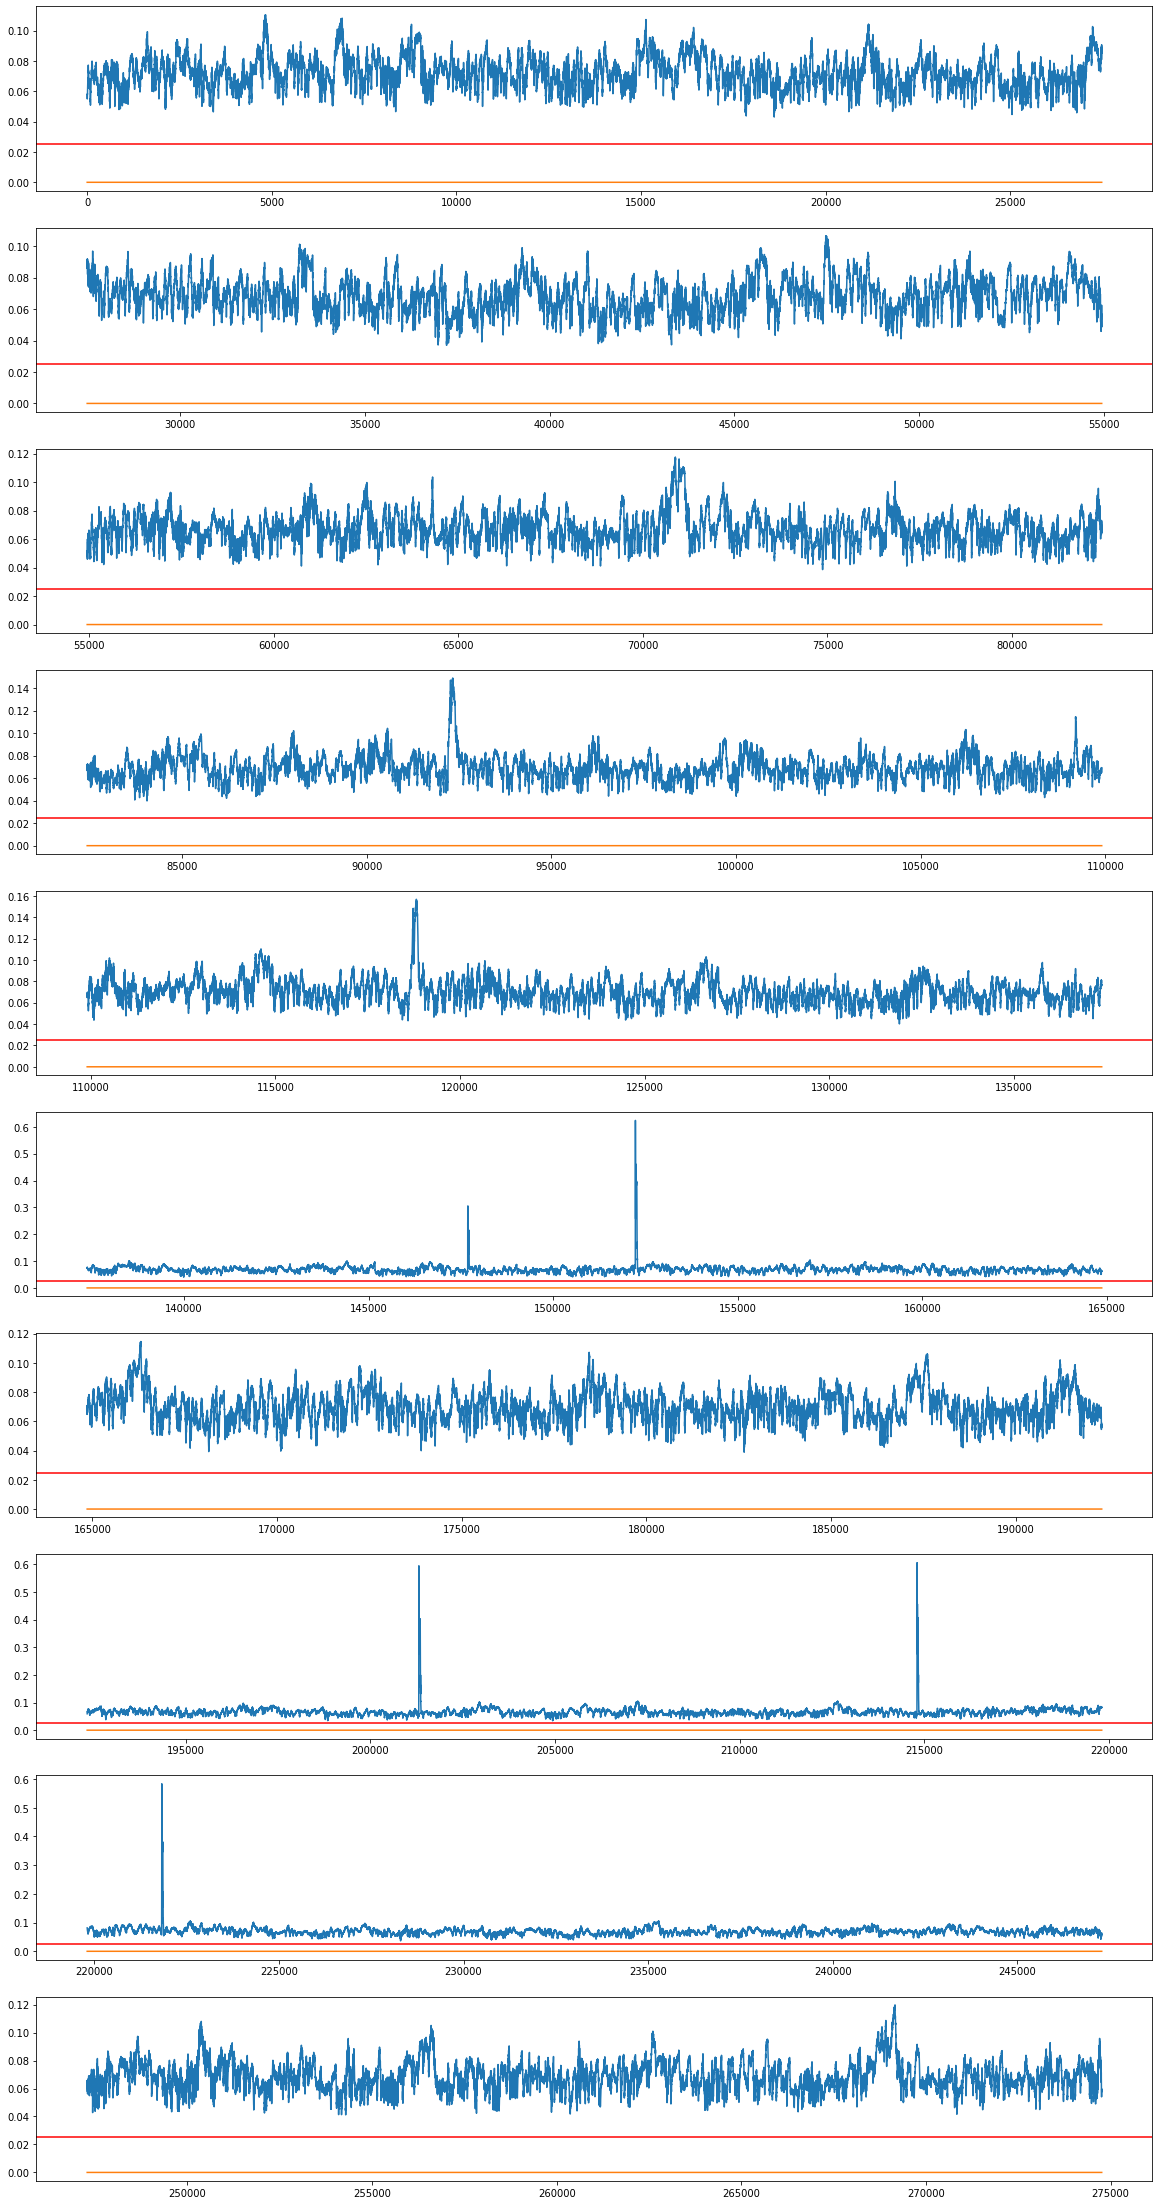

In [43]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=10, THRESHOLD=THRESHOLD)

In [44]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), (274764,))

In [45]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,1.0
2021-07-16 23:59:57,2021-07-16 23:59:57,1.0
2021-07-16 23:59:58,2021-07-16 23:59:58,1.0


In [46]:
submission.to_csv('SCI_baseline.csv', index=False)